In [8]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
#from google.colab import files

# **Split the data into training and testing datasets**
We can’t evaluate the predictive performance of our model with the same data we used for training. We need to evaluate the model with fresh data that hasn’t been seen by the model before. We accomplish that by splitting our dataset (training and test) before we use it.

1- The training set is applied to train, or fit, your model.

2- The test set is needed for an unbiased evaluation of the final model. We shouldn’t use it for fitting or validation.

In [10]:
data= pd.read_csv('../TSLA_Dataset.csv')
#Separate date for future plotting
train_dates = pd.to_datetime(data['Date'])

#Preparing the columns to be variables
cols = list(data)[1:5]

data.drop('Adj Close', axis=1, inplace=True)
data.drop('Volume', axis=1, inplace=True)
data_for_train=data[cols].astype(float)
#data.to_csv('TSLA_Dataset'+'_preprocessed.csv',index=False)
print(data_for_train.head())
data_for_train.describe()

        Open       High        Low      Close
0  44.618000  45.136002  44.450001  44.481998
1  44.574001  44.650002  42.652000  43.862000
2  42.910000  43.299999  41.431999  42.018002
3  42.012001  42.840000  40.841999  42.256001
4  42.669998  42.956001  41.956001  42.189999


,Open,High,Low,Close
count,1884.000000,1884.000000,1884.000000,1884.000000
mean,235.497948,240.848061,229.688691,235.426783
std,312.416755,319.784103,304.130902,312.065103
min,28.464001,30.993999,28.209999,28.733999
25%,47.385002,48.397999,46.717502,47.653500
50%,63.213002,64.347000,62.094999,63.274999
75%,328.939491,334.070008,311.800003,319.899505
max,1234.410034,1243.489990,1217.000000,1229.910034


# **Explaining our splitting**
We used the train_test_split() from sklearn.model_selection package. We divided our data into 2 main sets : a first set as inputs (x_dataset) and a second set as outputs (y_dataset). 
The inputs (x_dataset) have been divided into 2 subsets, training and testing (x_train_dataset and x_test_dataset respectively). The same operation was repeated for the outputs (y_train_dataset and y_test_dataset). The sizes of the subsets are 75% and 25% for the training and testing subsets. 
The outputs are going to be used later to assess the accuracy of our model, given the input data.

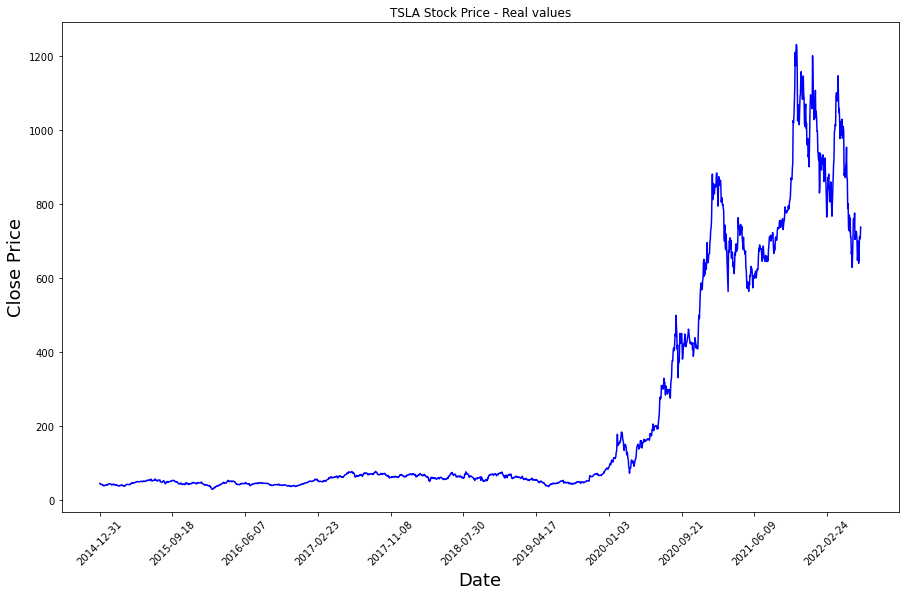

In [11]:
plt.figure(figsize = (15,9))
plt.plot((data_for_train['Close']), color='blue', label='TSLA')
plt.xticks(range(0,data.shape[0],180),data['Date'].loc[::180],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.title('TSLA Stock Price - Real values')
plt.show()

# **Scaling the data**
Feature scaling is the process of normalising the range of features in a dataset. Feature scaling in machine learning is one of the most critical steps during the pre-processing of data before creating a machine learning model. Scaling can make a difference between a weak machine learning model and a better one. Our datasets contain values that are varying in degrees of magnitude, range and units. Therefore, in order for our machine learning model to interpret these features on the same scale, we need to perform feature scaling. We will scale our data between 0 and 1.

The scaling function is given by the following :

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

In [12]:
from sklearn.preprocessing import MinMaxScaler

x_dataset=data_for_train.iloc[:,0:4].values
sc = MinMaxScaler(feature_range = (0, 1))
x_train_scaled=sc.fit_transform(x_dataset)
window_size=5
future_days=1
xtrain=[]
ytrain=[]
for i in range(window_size,len(x_train_scaled)-future_days+1):
    xtrain.append(x_train_scaled[i-window_size:i, 0:x_train_scaled.shape[1]])
    ytrain.append(x_train_scaled[i+future_days-1:i+future_days, 3])
xtrain, ytrain=np.array(xtrain),np.array(ytrain)
xtrain=np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],4))

# **Building our LSTM model**
Hre we build a simple model to resolve our prediction problem. It's characteristics are the following:
- 2 layers with layer 1 having 75 cells in the hidden layer with a dropout of 20%. Layer 2 has 50 cells with a dropout rate of 20%.
- We have just one feature as an output on the level of the Dense layer.
- We use "Adam" as an optimizer and we capture the loss with the "mean_squared_error".
- Our model has a validation split of 20% on the overall data produced, combined with a batch size of 64.
- We will train our model during 200 epochs
- As inputs, we take the "Low" column of our dataset, and we train it to predict the "Open" column of our dataset.

In [13]:
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()
regressor.add(LSTM(units = 75, activation='relu',return_sequences = True, input_shape = (xtrain.shape[1], xtrain.shape[2])))#Input layer
regressor.add(Dropout(0.1))
regressor.add(Bidirectional(LSTM(units = 50, return_sequences = False)))#Hidden layer 1
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 1))#Ouput layer
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse','accuracy'])
history=regressor.fit(xtrain, ytrain, epochs = 100, batch_size = 128, validation_split=0.3)
regressor.summary()

Epoch 1/100
11/11 [==============================] - 14s 177ms/step - loss: 3.2487e-04 - mse: 3.2487e-04 - accuracy: 7.6046e-04 - val_loss: 0.1899 - val_mse: 0.1899 - val_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 31ms/step - loss: 1.5602e-04 - mse: 1.5602e-04 - accuracy: 7.6046e-04 - val_loss: 0.0980 - val_mse: 0.0980 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 6.3462e-05 - mse: 6.3462e-05 - accuracy: 7.6046e-04 - val_loss: 0.0287 - val_mse: 0.0287 - val_accuracy: 0.0018
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 2.5270e-05 - mse: 2.5270e-05 - accuracy: 7.6046e-04 - val_loss: 0.0029 - val_mse: 0.0029 - val_accuracy: 0.0018
Epoch 5/100
11/11 [==============================] - 0s 21ms/step - loss: 2.2782e-05 - mse: 2.2782e-05 - accuracy: 7.6046e-04 - val_loss: 0.0040 - val_mse: 0.0040 - val_accuracy: 0.0018
Epoch 6/100
11/11 [==============================] - 0s 20ms

# **Plotting the learnings curves of our model**
Generally, a learning curve is a plot that shows time or experience on the x-axis and learning or improvement on the y-axis. 




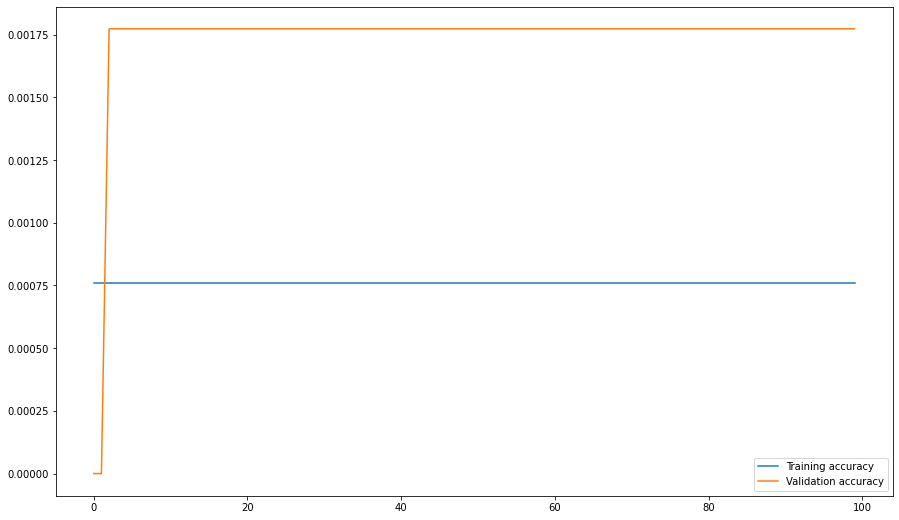

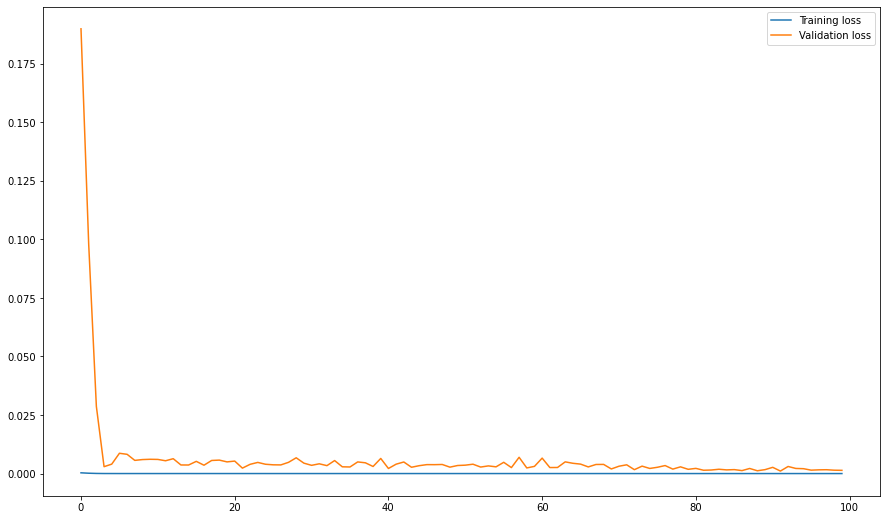

In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt


plt.figure(figsize = (15,9))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()
plt.figure(figsize = (15,9))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# **Plotting the predictions for all our selected companies**

# **Model predictions assessment and evaluation of forecasting accuracy**
Measuring the performance of any machine learning model is very important, not only from the technical point of view but also from the business perspective.
Time series prediction performance measurements provide a summary of the forecast model’s skill and capability in making the forecasts. There are numerous performance metrics from which to pick. 
We will use the following metrics to assess the performance of our model: 

1- Mean Absolute Error (MAE)  
2- Mean Absolute Percentage Error (MAPE)  
3- Root Mean Squared Error(RMSE)



Start of prediction for NVidia
5/5 [==============================] - 0s 9ms/step - loss: 9.9925e-16 - mse: 9.9925e-16 - accuracy: 0.0000e+00


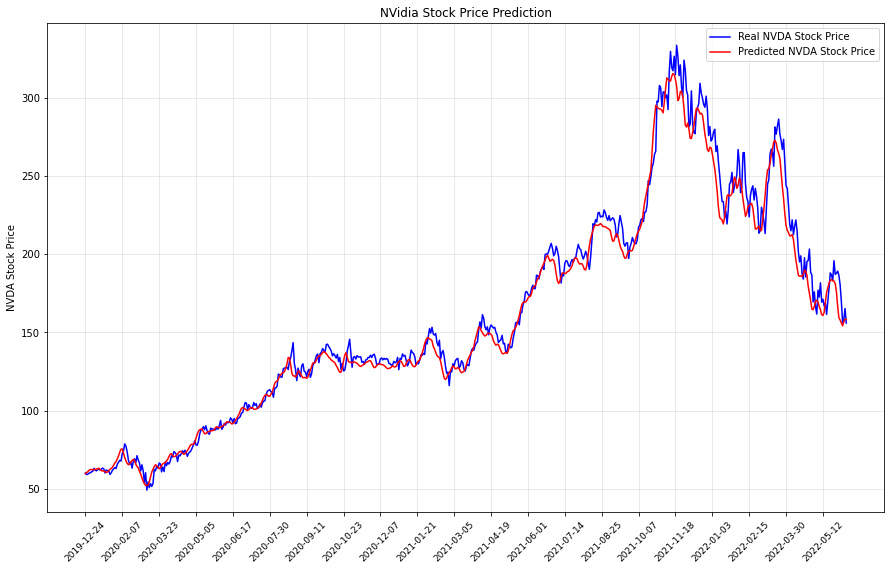

MAE 6.3331957158604775
MAPE 3.729847011869854
RMSE 9.219223570963631
r2 score =  0.9822968318012688
End of predictions for NVidia 

[9.992511206230025e-16, 9.992511206230025e-16, 0.0]


In [19]:
#Create a dictionnary for the list of our companies
#dic={
#    "AAPL":"Apple Inc.",
#    "BAC":"Bank of America Coorporation",
#    "BCS":"Barclays PLC",
#    "JPM":"JPMorgan Chase & Co.",
#    "SMSN.IL":"Samsung Electronics Co. Ltd."
#}
from sklearn.metrics import r2_score
#for j in company_list :
dataset= pd.read_csv('../NVDA_Dataset.csv')
print("Start of prediction for NVidia")
cols = list(dataset)[1:5]    
dataset.drop('Adj Close', axis=1, inplace=True)
dataset.drop('Volume', axis=1, inplace=True)
data_for_train=dataset[cols].astype(float)
x_dataset=data_for_train.iloc[1259:,0:4].values
realVal=data_for_train.iloc[1259:,3:4]
sc_real=MinMaxScaler(feature_range = (0, 1))
x_test_scaled=sc.fit_transform(x_dataset)
y_test_scaled=sc_real.fit_transform(realVal)
window_size=5
future_days=1
xtest=[]
    
for i in range(window_size,len(x_test_scaled)-future_days+1):
    xtest.append(x_test_scaled[i-window_size:i, 0:x_train_scaled.shape[1]])
    
xtest=np.array(xtest)
xtest=np.reshape(xtest,(xtest.shape[0],xtest.shape[1],4))
    
predict = regressor.predict(xtest)
scores=regressor.evaluate(xtest,predict,batch_size=128)
predict = sc_real.inverse_transform(predict)
plt.figure(figsize = (15,9))
plt.grid(which='major', color='#cccccc', alpha=0.5)
realVal2020=realVal[:len(x_dataset)-5]
realVal2020=np.array(realVal2020)
plt.plot(realVal2020, color = 'blue', label = 'Real NVDA Stock Price')
plt.plot(predict, color = 'red', label = 'Predicted NVDA Stock Price')
plt.title('NVidia Stock Price Prediction')
plt.xticks(range(0,realVal.shape[0],30),dataset['Date'].loc[len(dataset)-len(realVal)-5::30],rotation=45,fontsize=9)
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()
 
    ##############################################################
    #### We now compute the error metrics for each prediction ####
    ####             and we store them in a tuple             ####
    ##############################################################
new_MAE=mean_absolute_error(realVal2020,predict)
print("MAE",new_MAE)
new_MAPE=mean_absolute_percentage_error(realVal2020,predict)
print("MAPE",new_MAPE*100)
new_RMSE=mean_squared_error(realVal2020,predict,squared=False)
print("RMSE",new_RMSE)
r=r2_score(realVal2020, predict)
print("r2 score = ",r)
print("End of predictions for NVidia \n")
print(scores)

# **Plotting the model performance & cross-validation**
Generally, a learning curve is a plot that shows time or experience on the x-axis and learning or improvement on the y-axis. 




C:\Users\HP\AppData\Local\Temp\ipykernel_16892\4257198227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions']=predict


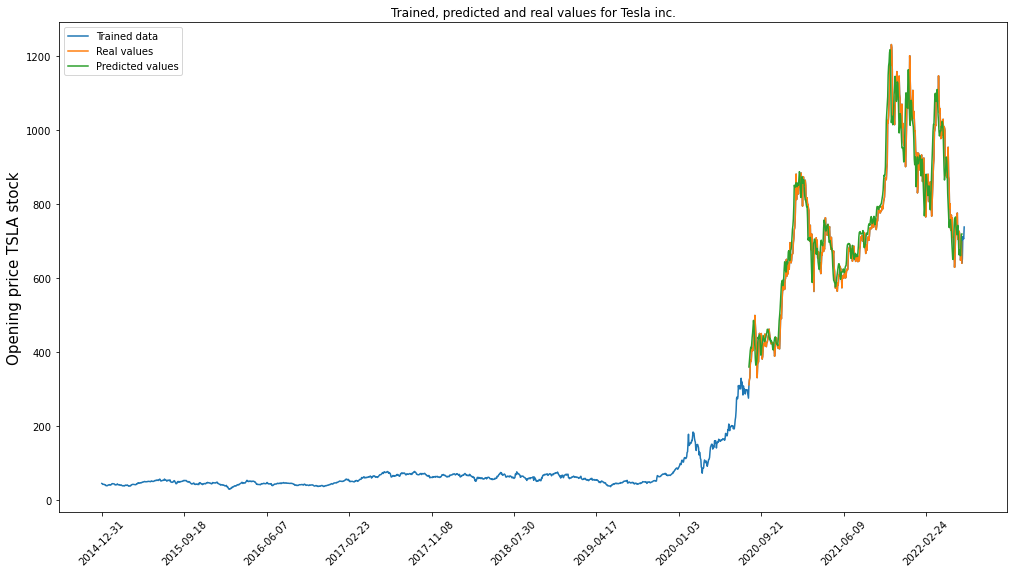

In [122]:
valid=Ytest[:len(Ytest)-5]
valid['predictions']=predict
plt.figure(figsize = (17,9))
plt.title("Trained, predicted and real values for "+company_name[5])
plt.xticks(range(0,data.shape[0],180),data['Date'].loc[::180],rotation=45)
plt.ylabel('Opening price '+j+' stock', fontsize=15)
plt.plot(range(data.shape[0]),(data['Close']))
plt.plot(valid[['Close','predictions']])
plt.legend(['Trained data', 'Real values', 'Predicted values'])
plt.show()